# Inside A CNN✨
Visualizing Feature Representation of Convolutional Neural Networks.

---
🦫Kurw.AI❤️‍🔥 2025.

### Table Of Contents.

1) Deconvolution <br>
2) Synthetic Images <br>
3) DeepDream <br>

In [2]:
import torch
from torchvision import models, transforms
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Deconvolution
Deconvolution is a technique for figuring out significance of each pixel to corresponding neuron.<br>
In other words, through backpropagation process w.r.t input image we can see which features of the image are important for particular neuron in a layer.<br>
I like this idea for its simplicity. Let's roll!

In [3]:
model = models.vgg19(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.7MB/s]


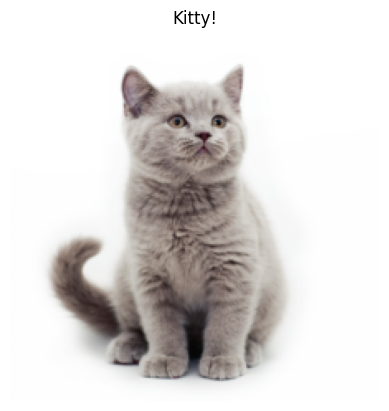

In [4]:
image = Image.open("cat.png").convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input = transform(image).unsqueeze(0)

plt.axis("off")
plt.title("Kitty!")
plt.imshow(input.squeeze(0).permute(1, 2, 0));

In [5]:
# Let's see the influence of this little gentlement on randomly picked neuron
# From last layer
input.requires_grad = True

output = model(input)
output[0, 34].backward()  # 34th class in imagenet

In [6]:
input.grad.shape  # This is possible to visualize!

torch.Size([1, 3, 224, 224])

In [7]:
gradient = input.grad
grad_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)

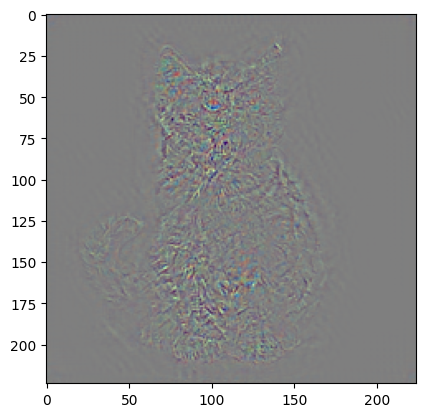

In [8]:
plt.imshow(grad_norm.squeeze(0).permute(1, 2, 0));

Oh... This is... Well not what we wanted...<br>
It looks promising, because we can see cat figure, but what's wrong with this visualization?<br>
The answer is simple: we calculated all gradients, we displayed all the calculated gradients.<br>
Instead, we'd rather display features with positive gradient and positive input to the neuron.<br>
But how to do this filtering?<br>
The answer is... Well... Counterintuitive.<br>
We replace default ReLU with our own implementation for this filtering.<br>
It is called a "Guided Backpropagation"

In [9]:
input.grad.zero_()  # IMPORTANT!

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [10]:
class GuidedReLU(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    output = torch.relu(input)
    return output

  @staticmethod
  def backward(ctx, grad_out):
    input, = ctx.saved_tensors
    grad = grad_out.clone()
    grad[input <= 0] = 0  # Set grad to 0 where input is negative (ReLU) doesn't fire
    grad[grad_out <= 0] = 0  # Set grad to 0 where outer gradient is negative

    return grad

In [11]:
class GuidedReLUModule(nn.Module):
  def forward(self, input):
    output = GuidedReLU.apply(input)
    return output

In [12]:
# Now we need to replace ReLUs with GuidedReLUs.

def replace_relus(module):
  for name, child in module.named_children():
    if isinstance(child, nn.ReLU):
      setattr(module, name, GuidedReLUModule())
    else:
      replace_relus(child)

In [13]:
# Okay, we're done!
# Time to test on the last layer!

replace_relus(model)
output = model(input)
output[0, 34].backward()  # 34th class in imagenet

In [14]:
input.grad.shape

torch.Size([1, 3, 224, 224])

In [15]:
gradient = input.grad
grad_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)

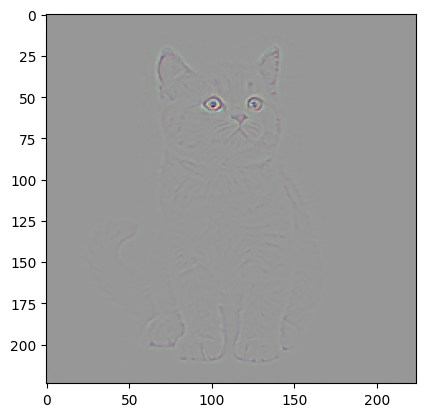

In [16]:
plt.imshow(grad_norm.squeeze(0).permute(1, 2, 0));  # Yo!

Hell yeah! Here's our pretty fancy cool cutie baby!<br>
For reasons mentioned above we get much better result when denoising this gradient heatmap and focusing only on important parts.<br>
**But can we show this effect on inner neurons?**
<br>Sure!

In [17]:
layers = []


def flatten_network(module):
  for name, child in module.named_children():
    if not list(child.children()):
      layers.append(child)
    else:
      flatten_network(child)

flatten_network(model)

In [18]:
input.grad.zero_()

grads = []

for i in range(1, 21):
  out = input
  for layer in layers[:i]:
    out = layer(out)

  scalar = out.sum()
  scalar.backward()
  grads.append(input.grad.detach().clone())
  input.grad.zero_()

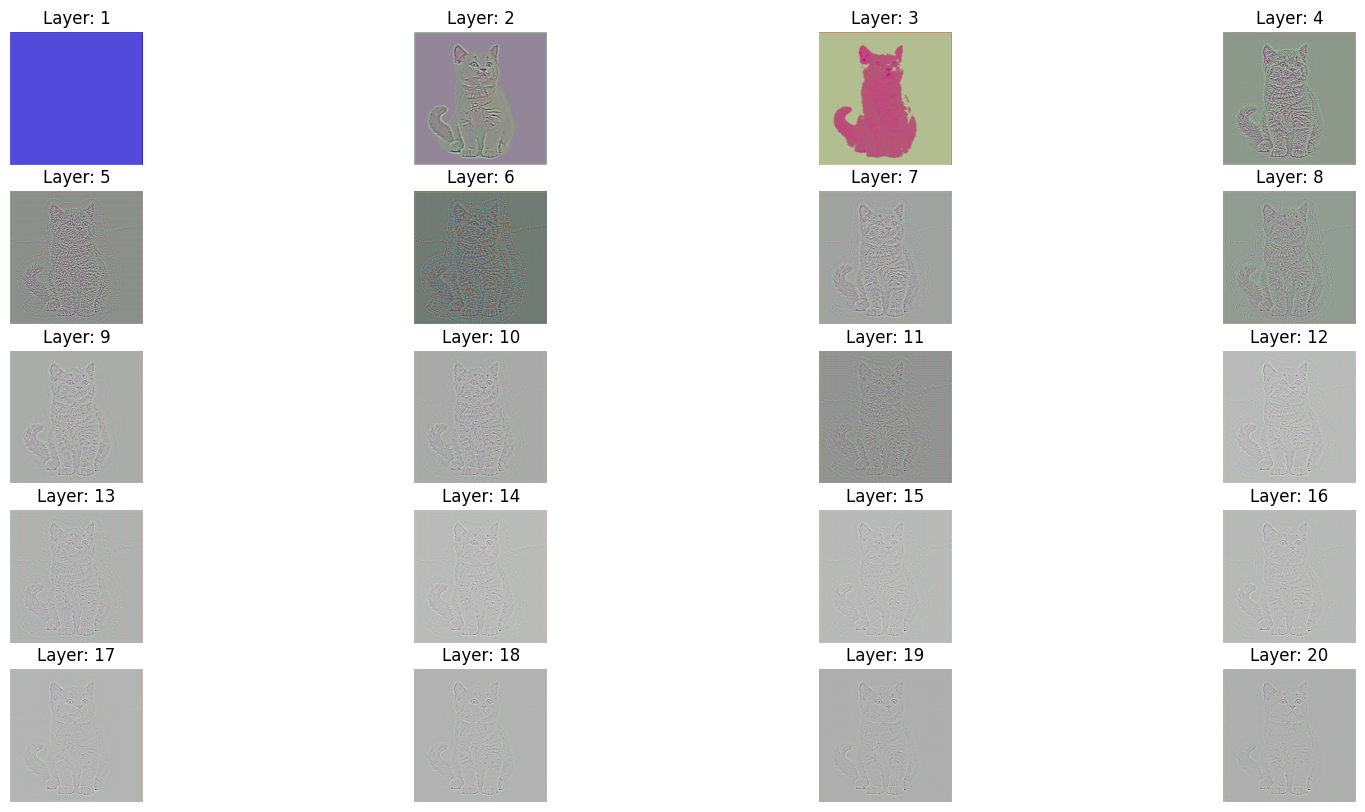

In [19]:
plt.figure(figsize=(20, 10))
for n, grad in enumerate(grads):
  grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
  plt.subplot(5, 4, n+1)
  plt.axis("off")
  plt.title(f"Layer: {n+1}")
  plt.imshow(grad.squeeze(0).permute(1, 2, 0))

Awesome!<br>
I think it's high time we're done with gradient visualizations.<br>
To sum up, it's just a visualization of how strong is the effect of each pixel per neuron/layer.<br>
It is a very simple idea with a clumsy implementation, but I love it!
It's just superb!

# Synthetic Neuron Maximization.
Okay, this is pretty simple.<br>
One day, one guy decided that we can do gradient ascent to maximize particular feature and to update input.<br>
We pass zeros as for input, but then we start updating it.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
from tqdm import tqdm

In [22]:
model = models.vgg19(pretrained=True)

In [23]:
def visualize_class(idx):
  input = torch.rand((1, 3, 224, 224), device=device, requires_grad=True)
  # input = torch.zeros((1, 3, 224, 224), device=device, requires_grad=True)

  optimizer = optim.SGD([input], lr=0.1)
  EPOCHS = 500

  model.to(device)
  model.eval()

  for epoch in tqdm(range(EPOCHS)):
      output = model(input)
      loss = -output[0, idx] + 0.3 * torch.norm(input, 2)  # L2 regularization

      if epoch % 10 == 0:
        input.data = torch.nn.functional.avg_pool2d(input.data, kernel_size=3, stride=1, padding=1)

      if epoch % 100 == 0:
          print(f"Epoch {epoch}, score: {-loss.item():.4f}")

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
          input.data = torch.clamp(input.data, 0, 1)

      res_img = input.clone().detach().cpu()
      plt.imshow(res_img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy());

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, score: -67.3768


 21%|██        | 104/500 [00:05<00:15, 25.27it/s]

Epoch 100, score: 163.2037


 41%|████      | 203/500 [00:09<00:11, 25.12it/s]

Epoch 200, score: 286.5774


 61%|██████    | 305/500 [00:13<00:07, 24.76it/s]

Epoch 300, score: 326.1859


 81%|████████  | 404/500 [00:17<00:03, 24.70it/s]

Epoch 400, score: 368.0469


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


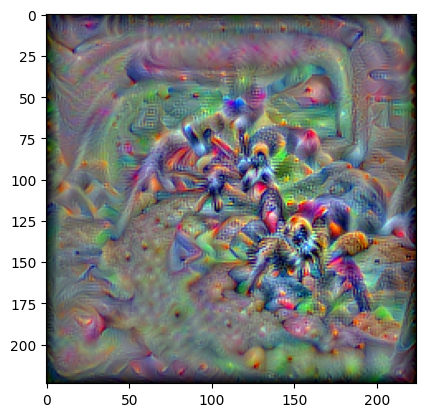

In [24]:
visualize_class(76)  # Tarantula

  0%|          | 2/500 [00:00<00:32, 15.15it/s]

Epoch 0, score: -67.4164


 21%|██        | 103/500 [00:04<00:16, 24.67it/s]

Epoch 100, score: 58.8948


 41%|████      | 205/500 [00:08<00:11, 24.72it/s]

Epoch 200, score: 182.6627


 61%|██████    | 304/500 [00:12<00:07, 24.76it/s]

Epoch 300, score: 237.9322


 81%|████████  | 403/500 [00:16<00:03, 24.72it/s]

Epoch 400, score: 281.6905


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


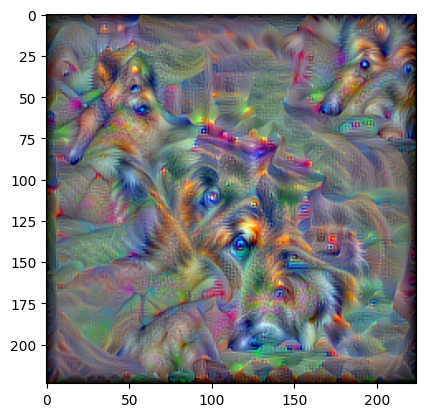

In [25]:
visualize_class(231)  # Collie

  0%|          | 2/500 [00:00<00:32, 15.36it/s]

Epoch 0, score: -68.7521


 21%|██        | 103/500 [00:04<00:16, 24.80it/s]

Epoch 100, score: 66.1091


 41%|████      | 205/500 [00:08<00:12, 24.57it/s]

Epoch 200, score: 193.5316


 61%|██████    | 304/500 [00:12<00:07, 24.78it/s]

Epoch 300, score: 257.9687


 81%|████████  | 403/500 [00:16<00:03, 24.75it/s]

Epoch 400, score: 285.3813


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


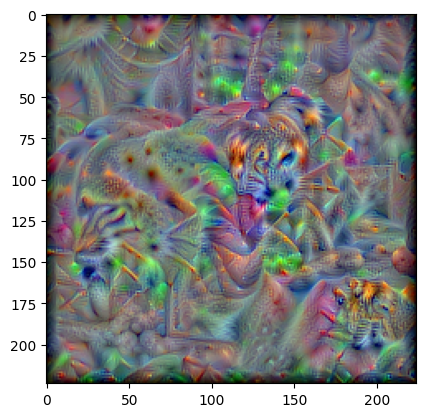

In [26]:
visualize_class(292)  # Tiger

**AWESOME!**
If you don't understand what's going on, let me explain.<br>
We try to maximize picked class logit in final layer, every 10th epoch we blur image as a regularization technique.<br>
We optimizer random noise to maximize class generating interesting class visualization from it.

# Deep Dream Visualization
Deep Dream is another super cool visualization technique.<br>
I really like the way Tensorflow Blog (https://www.tensorflow.org/tutorials/generative/deepdream) describes it as an **"experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image."**

In [88]:
model = models.vgg19(pretrained=True).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
img = Image.open("simon.jpg").convert("RGB")
original_size = img.size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_img = transform(img).to(device)

In [150]:
activations = {}
def save_output_hook(module, input, output):
  activations["value"] = output

def dream_step(inp, net, layer, lr=0.01):
  inp = inp.unsqueeze(0).cuda()
  inp.requires_grad = True
  net.zero_grad()
  hook = layer.register_forward_hook(save_output_hook)
  net(inp)
  loss = activations["value"].norm()
  loss.backward()
  hook.remove()
  return inp.grad.data.squeeze()


def dream(image, model, layer, iterations, lr):
  for iteration in range(iterations):
    grad = dream_step(image, model, layer, lr)
    image.data = image.data + lr * grad

  img_out = image.detach().cpu()
  img_out_np = img_out.numpy().transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

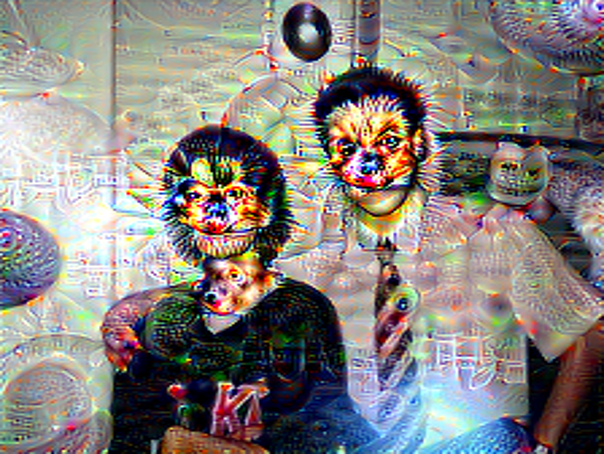

In [94]:
layer = list(model.features.modules())[27]
img = dream(input_img, model, layer, 100, 0.01)
img.resize(original_size)

**Wow! That's good!**
One problem here, all these dreams have the same size (granularity)<br>
How do we fix it?
We could do this process multiple times changing the size of image after every dream.

In [110]:
import torch.nn.functional as F

def resize_image(img_tensor, size):
    # img_tensor: shape [1, C, H, W]
    return F.interpolate(img_tensor, size=size, mode='bilinear', align_corners=False)

def deep_dream_with_octaves(image, model, layer, iterations, lr, octaves, octave_scale=1.4):
    """Perform DeepDream at multiple octaves (scales)."""
    original_shape = image.shape[-2:]  # [H, W]
    image = image.unsqueeze(0).cuda()

    # For each
    for octave in range(octaves):
        scale = octave_scale ** (octaves - octave - 1)
        new_size = [int(dim / scale) for dim in original_shape]
        image = resize_image(image, new_size)

        # 2. Dream on the scale
        for _ in range(iterations):
            grad = dream_step(image.squeeze(0), model, layer, lr)
            with torch.no_grad():
                image = image + lr * grad.unsqueeze(0)

        # 3. Upscale back
        image = resize_image(image, original_shape)

    # Final image formatting
    image = image.squeeze(0).detach().cpu()
    image_np = image.numpy().transpose(1, 2, 0)
    image_np = np.clip(image_np, 0, 1)
    return Image.fromarray(np.uint8(image_np * 255))

In [111]:
img = Image.open("simon.jpg").convert("RGB")
original_size = img.size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_img = transform(img).to(device)

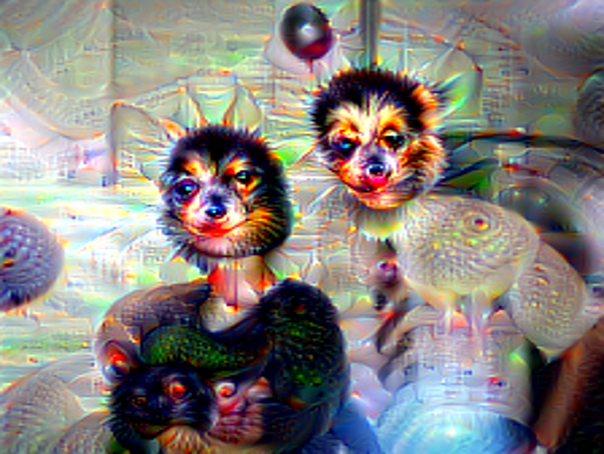

In [118]:
img = deep_dream_with_octaves(input_img, model, layer, 20, 0.01, 3, 1.4)
img.resize(original_size)

As we repeat this process multiple times (number of octaves) it gets crazier over time.<br>
The higher the scaling factor is, the bigger the varience of object sizes.<br>
By the way, we dreamt only on this layer, let's try others!

In [151]:
layer_info = [(i, layer) for i, layer in enumerate(model.features) if isinstance(layer, (nn.Conv2d))]
res_imgs = []

for idx, (layer_idx, layer) in enumerate(layer_info):
    try:
        img = Image.open("simon.jpg").convert("RGB")
        original_size = img.size

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        input_img = transform(img).to(device)

        # Fetch the actual layer from model.features
        hooked_layer = model.features[layer_idx]
        img = dream(input_img, model, hooked_layer, 20, 0.01)

        image = img.resize(original_size)
        res_imgs.append(image)
    except Exception as e:
        print(f"Error at layer {idx}: {e}")
        continue

In [152]:
tensors = []
for image in res_imgs:
  tensors.append(transforms.ToTensor()(image))

In [153]:
len(tensors)

16

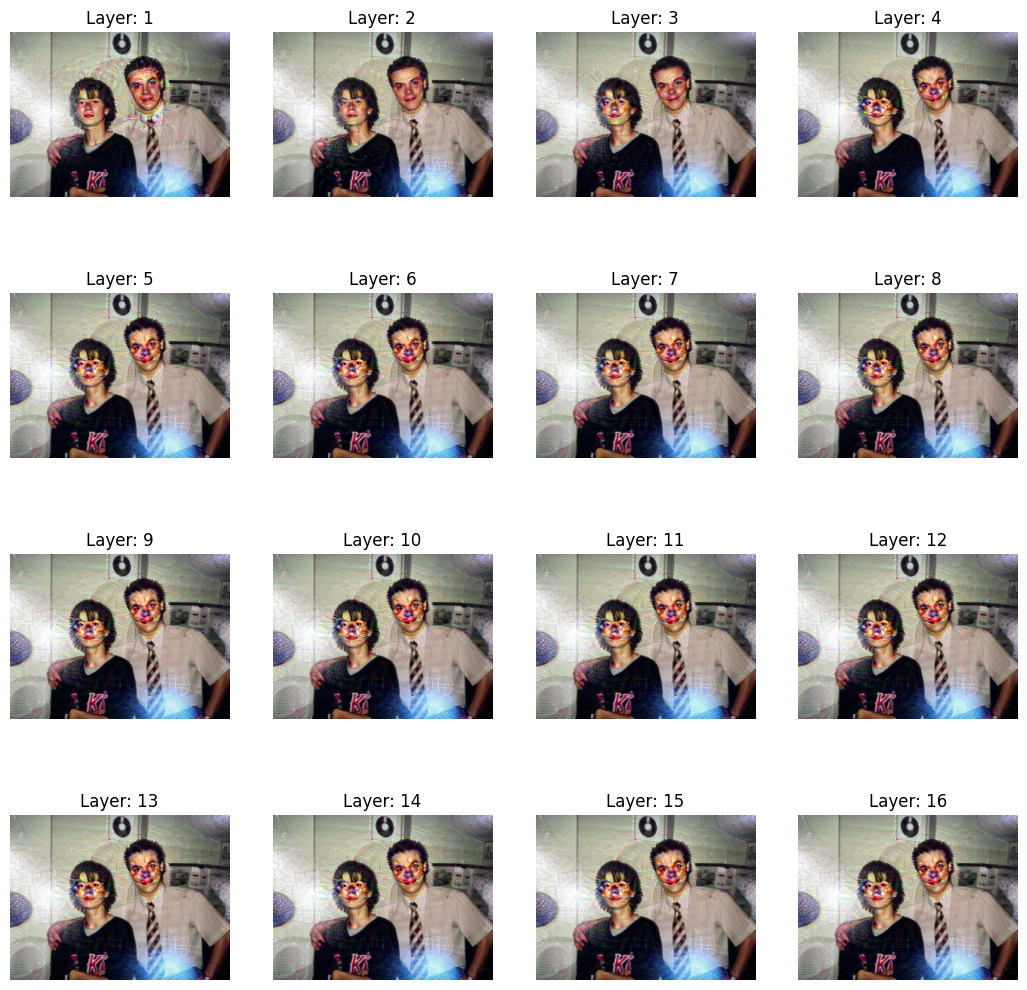

In [155]:
plt.figure(figsize=(13, 13))
for n, dream in enumerate(reversed(tensors)):
  plt.subplot(4, 4, n+1)
  plt.axis("off")
  plt.title(f"Layer: {n+1}")
  plt.imshow(dream.squeeze(0).permute(1, 2, 0))

In [157]:
layer_info = [(i, layer) for i, layer in enumerate(model.features) if isinstance(layer, (nn.Conv2d))]
res_imgs = []

for idx, (layer_idx, layer) in enumerate(layer_info):
    try:
        img = Image.open("simon.jpg").convert("RGB")
        original_size = img.size

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        input_img = transform(img).to(device)

        # Fetch the actual layer from model.features
        hooked_layer = model.features[layer_idx]
        img = deep_dream_with_octaves(input_img, model, hooked_layer, 20, 0.01, 3, 1.4)

        image = img.resize(original_size)
        res_imgs.append(image)
    except Exception as e:
        print(f"Error at layer {idx}: {e}")
        continue

In [158]:
tensors = []
for image in res_imgs:
  tensors.append(transforms.ToTensor()(image))

In [159]:
len(tensors)

16

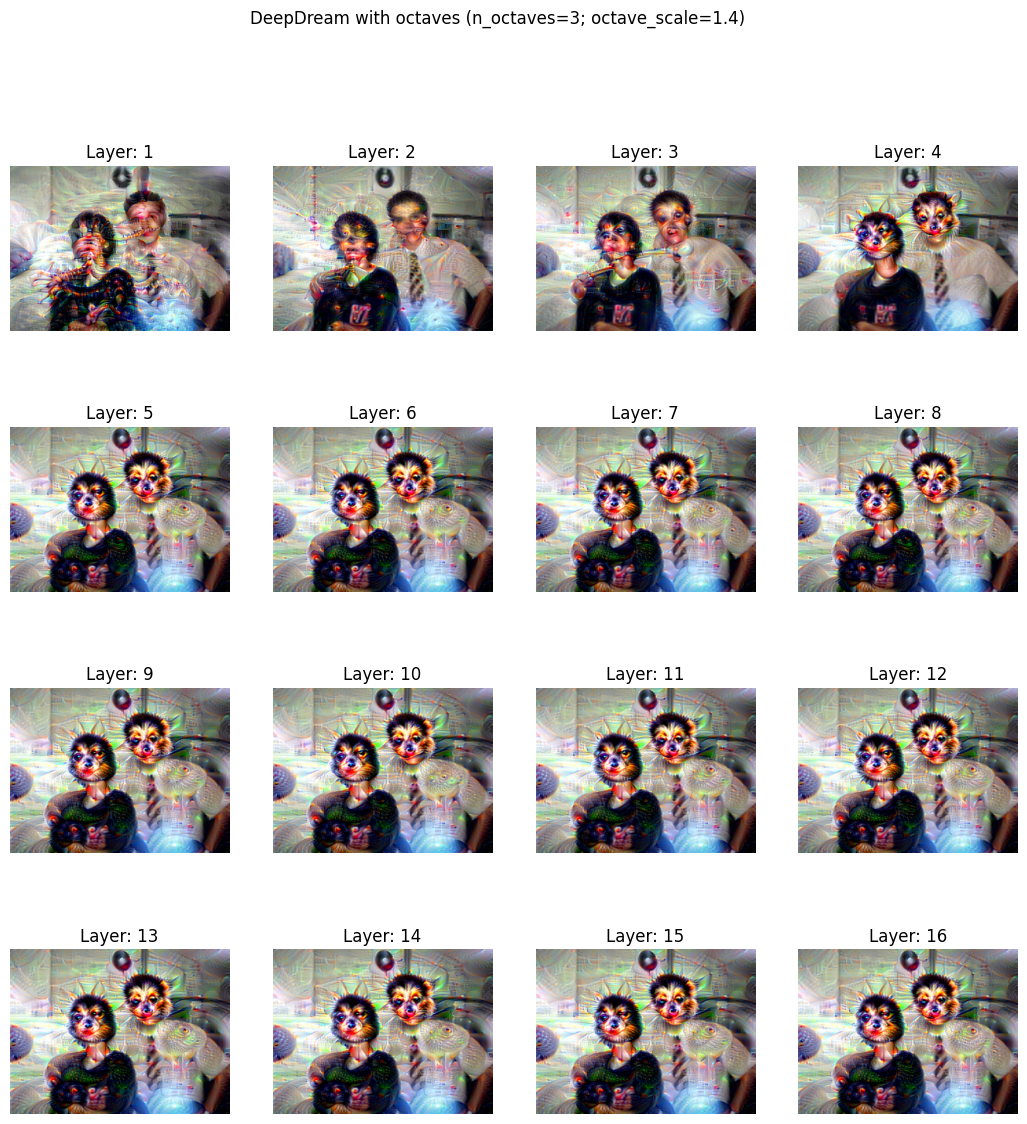

In [160]:
plt.figure(figsize=(13, 13))
plt.suptitle("DeepDream with octaves (n_octaves=3; octave_scale=1.4)")
for n, dream in enumerate(reversed(tensors)):
  plt.subplot(4, 4, n+1)
  plt.axis("off")
  plt.title(f"Layer: {n+1}")
  plt.imshow(dream.squeeze(0).permute(1, 2, 0))

In [196]:
img = Image.open("sky.jpg").convert("RGB")
original_size = img.size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_img = transform(img).to(device)

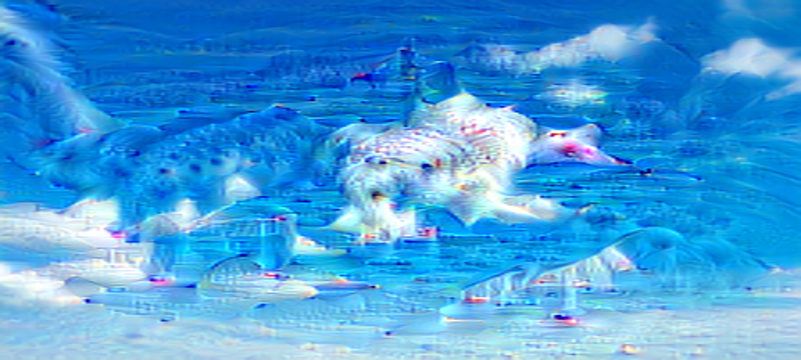

In [197]:
img = deep_dream_with_octaves(input_img, model, layer, 15, 0.01, 3, 1.4)
img.resize(original_size)

Dogs even here (due to many dog classes in ImageNet)

# Alright!
Today we did a big deal! Today we've learnt:<br>
1) How to visualize important image parts with deconvolution
2) How to generate the colliest collie
3) How neural networks can dream

I personally learnt a lot and had a lot of fun and struggle(sometimes) coding this notebook, learnt about PyTorch hooks and all these techniques.<br>
See ya!